In [1]:
# pip install git+https://github.com/5121eun/dl

  Cloning https://github.com/5121eun/dl to /tmp/pip-req-build-7dkei0y3
  Running command git clone --filter=blob:none --quiet https://github.com/5121eun/dl /tmp/pip-req-build-7dkei0y3
  Resolved https://github.com/5121eun/dl to commit 39846d70f01d0d0c10c3679cdc1108a70f7b963d
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from models.mae import *

In [3]:
batch_size = 32

n_channels = 3
image_size = 32
patch_size = 2
n_tokens = int((image_size/patch_size) ** 2)

enc_dim = 256
dec_dim = 128

enc_depth = 4
dec_depth = 2

enc_nheads = 4
dec_nheads = 4

masking_ratio = 0.75

lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('dataset/', train = True, download = True,
                 transform = transforms.Compose([
                     transforms.ToTensor()
                 ])),
    batch_size = batch_size)

Files already downloaded and verified


In [5]:
model = MAE(n_channels, patch_size, n_tokens, enc_dim, dec_dim, enc_depth, dec_depth, enc_nheads, dec_nheads).to(device)
model_opt = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.95), lr=lr)
os = []

In [6]:
for i in range(150):
    for feature, label in iter(train_loader):
        unmask_idx = np.random.choice(n_tokens, int(n_tokens * (1 - masking_ratio)), replace=False)
        mask_idx = list(range(n_tokens))
        [mask_idx.remove(i) for i in unmask_idx]

        out = model(feature.to(device), unmask_idx)
        loss = nn.MSELoss()(out[:, mask_idx].view(batch_size, -1), patch(feature, patch_size)[:, mask_idx].view(batch_size, -1).to(device))

        model_opt.zero_grad()
        loss.backward()
        model_opt.step()
    os.append(unpatch(out.detach().cpu(), image_size, image_size))
    print(f"{i}: {loss.item()}")

0: 0.05136758089065552
1: 0.04848618432879448
2: 0.04863608628511429
3: 0.04634823277592659
4: 0.040491919964551926
5: 0.039794206619262695
6: 0.03174698352813721
7: 0.037092555314302444
8: 0.030184978619217873
9: 0.02961648255586624
10: 0.028681302443146706
11: 0.028749043121933937
12: 0.032340534031391144
13: 0.028689421713352203
14: 0.028197474777698517
15: 0.02865293249487877
16: 0.02981051430106163
17: 0.024468395859003067
18: 0.026569867506623268
19: 0.027808064594864845
20: 0.02408825047314167
21: 0.02472633682191372
22: 0.025787590071558952
23: 0.02772931382060051
24: 0.028614521026611328
25: 0.024155372753739357
26: 0.02520165778696537
27: 0.02582136169075966
28: 0.02280309423804283
29: 0.025181224569678307
30: 0.021792743355035782
31: 0.025273779407143593
32: 0.024207977578043938
33: 0.024470381438732147
34: 0.025589467957615852
35: 0.022449007257819176
36: 0.021237578243017197
37: 0.02546672709286213
38: 0.020672941580414772
39: 0.02070021443068981
40: 0.022998087108135223
4

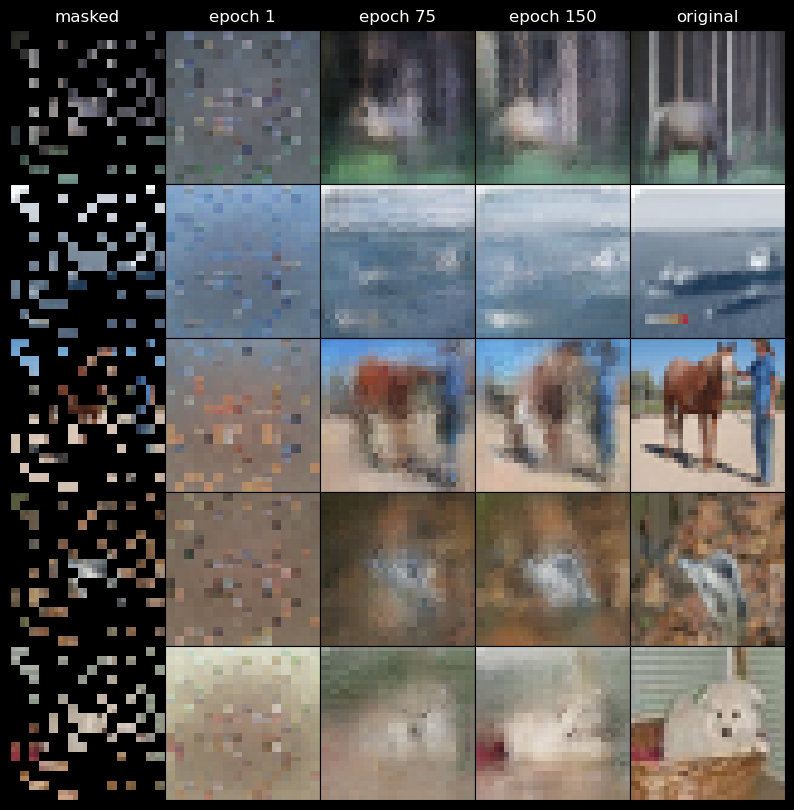

In [7]:
maksed_input = patch(feature, patch_size)
maksed_input[:, mask_idx] = maksed_input[:, mask_idx] * 0
masked_input = unpatch(maksed_input, image_size, image_size).to('cpu')

num = 5
outputs_len = len(os)
outputs_num = 3
figsize = 10

columns = ["masked", "epoch 1", f"epoch {outputs_len//2}", f"epoch {outputs_len}", "original"]

fig, axes = plt.subplots(nrows=num, ncols=outputs_num + 2, figsize=(figsize, figsize))
for i in range(5):
    axes[0][i].set_title(columns[i], color='white')

    axes[i][0].imshow(masked_input[i], aspect='auto')
    axes[i][1].imshow(os[0][i], aspect='auto')
    axes[i][2].imshow(os[outputs_len//2][i], aspect='auto')
    axes[i][3].imshow(os[-1][i], aspect='auto')
    axes[i][4].imshow(feature[i].permute(1, 2, 0), aspect='auto')

plt.setp(axes, xticks=[], yticks=[])
fig.set_facecolor('black')
plt.subplots_adjust(wspace=0, hspace=0)

In [8]:
torch.save(model.state_dict(), "model.pt")